# 注意评分功能
:label:`sec_attention-scoring-functions`

在 :numref:`sec_nadaraya-waston` 中，我们使用高斯内核来模拟查询和键之间的交互。将 :eqref:`eq_nadaraya-waston-gaussian` 中的高斯内核的指数视为 * 注意力评分函数 *（简称 * 评分函数 *），这个函数的结果基本上被输入了 softmax 操作。因此，我们获得了与键配对的值的概率分布（注意力权重）。最后，注意力集中的输出只是基于这些注意力权重的值的加权总和。

从较高层面来说，我们可以使用上述算法实例化 :numref:`fig_qkv` 中的注意机制框架。:numref:`fig_attention_output` 表示 $a$ 的注意力评分函数，说明了如何将注意力集中的输出计算为加权值和。由于注意力权重是概率分布，因此加权总和基本上是加权平均值。

![Computing the output of attention pooling as a weighted average of values.](../img/attention-output.svg)
:label:`fig_attention_output`

从数学上讲，假设我们有一个查询 $\mathbf{q} \in \mathbb{R}^q$ 和 $m$ 键值对 $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，其中任何 $\mathbf{k}_i \in \mathbb{R}^k$ 和任何 $\mathbf{v}_i \in \mathbb{R}^v$。注意力池 $f$ 被实例化为值的加权总和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling`

其中查询 $\mathbf{q}$ 和键 $\mathbf{k}_i$ 的注意力权重（标量）是通过注意力评分函数 $a$ 的 softmax 运算计算的，该函数将两个向量映射到标量：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

正如我们所看到的，注意力评分功能 $a$ 的不同选择导致不同的注意力集中行为。在本节中，我们将介绍两个流行的评分功能，我们稍后将用来开发更复杂的注意力机制。


In [1]:
import math
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## 蒙面 Softmax 操作

正如我们刚才提到的，softmax 运算用于输出概率分布作为注意力权重。在某些情况下，并非所有的价值都应该被纳入注意力集中。例如，为了在 :numref:`sec_machine_translation` 中高效处理微型批量，某些文本序列填充了没有意义的特殊令牌。为了将注意力集中在仅作为值的有意义的令牌上，我们可以指定一个有效的序列长度（以令牌数表示），以便在计算 softmax 时过滤掉超出此指定范围的那些。通过这种方式，我们可以在下面的 `masked_softmax` 函数中实现这样的 * 掩码 softmax 操作 *，其中任何超出有效长度的值都被掩盖为零。


In [2]:
#@save
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return npx.softmax(X)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = valid_lens.repeat(shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = npx.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, True,
                              value=-1e6, axis=1)
        return npx.softmax(X).reshape(shape)

为了演示此函数的工作原理，请考虑由两个 $2 \times 4$ 矩阵示例组成的小批量，其中这两个示例的有效长度分别为 2 和 3 个。由于蒙面 softmax 操作，超出有效长度的值都被掩盖为零。


In [3]:
masked_softmax(np.random.uniform(size=(2, 2, 4)), np.array([2, 3]))

array([[[0.488994  , 0.511006  , 0.        , 0.        ],
        [0.4365484 , 0.56345165, 0.        , 0.        ]],

       [[0.288171  , 0.3519408 , 0.3598882 , 0.        ],
        [0.29034296, 0.25239873, 0.45725837, 0.        ]]])

同样，我们也可以使用二维张量为每个矩阵示例中的每一行指定有效长度。


In [4]:
masked_softmax(np.random.uniform(size=(2, 2, 4)), np.array([[1, 3], [2, 4]]))

array([[[1.        , 0.        , 0.        , 0.        ],
        [0.35848376, 0.3658879 , 0.27562833, 0.        ]],

       [[0.54370314, 0.45629686, 0.        , 0.        ],
        [0.19598778, 0.25580427, 0.19916739, 0.3490406 ]]])

## 添加剂注意
:label:`subsec_additive-attention`

一般来说，当查询和键是不同长度的矢量时，我们可以使用附加注意力作为评分功能。给定查询 $\mathbf{q} \in \mathbb{R}^q$ 和关键 $\mathbf{k} \in \mathbb{R}^k$，* 加法注意 * 评分功能

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

其中可学习的参数 $\mathbf W_q\in\mathbb R^{h\times q}$、$\mathbf W_k\in\mathbb R^{h\times k}$ 和 $\mathbf w_v\in\mathbb R^{h}$。相当于 :eqref:`eq_additive-attn`，查询和密钥被连接在一个 MLP 中，其中包含一个隐藏层，其隐藏单位的数量为 $h$，这是一个超参数。通过使用 $\tanh$ 作为激活函数和禁用偏见术语，我们将在以下内容中实现附加注意。


In [5]:
#@save
class AdditiveAttention(nn.Block):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        # Use `flatten=False` to only transform the last axis so that the
        # shapes for the other axes are kept the same
        self.W_k = nn.Dense(num_hiddens, use_bias=False, flatten=False)
        self.W_q = nn.Dense(num_hiddens, use_bias=False, flatten=False)
        self.w_v = nn.Dense(1, use_bias=False, flatten=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = np.expand_dims(queries, axis=2) + np.expand_dims(
            keys, axis=1)
        features = np.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = np.squeeze(self.w_v(features), axis=-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return npx.batch_dot(self.dropout(self.attention_weights), values)

让我们用一个玩具示例来演示上面的 `AdditiveAttention` 类，其中查询、键和值的形状（批量大小、步数或令牌序列长度、特征大小）分别为（73229293618、$1$、$20$）、（$10$、$2$、$2$）和（73229293615、$2$、$10$）和（73229293615、$10$）和（73229293615、$10$、$10$）和（73229293615、$10$、$10$），$4$）。注意力池输出的形状为（批量大小、查询的步骤数、值的要素大小）。


In [6]:
queries, keys = np.random.normal(0, 1, (2, 1, 20)), np.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
values = np.arange(40).reshape(1, 10, 4).repeat(2, axis=0)
valid_lens = np.array([2, 6])

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.initialize()
attention(queries, keys, values, valid_lens)

array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]])

尽管加法注意力包含可学习的参数，但由于本例中每个键都是相同的，所以注意力权重是一致的，由指定的有效长度决定。


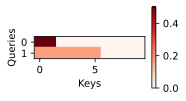

In [7]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 缩放点-产品关注

计分功能的计算效率更高的设计可以简单地是点积。但是，点积操作要求查询和键具有相同的矢量长度，比如 $d$。假设查询的所有元素和关键字都是独立的随机变量，均值和单位方差零。两个向量的点积均值为零，方差为 $d$。为确保无论矢量长度如何，点积的方差仍然是一个，* 缩放的点积注意 * 评分功能

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}$$

将点积除以 $\sqrt{d}$。在实践中，我们通常以微型批量来考虑提高效率，例如 $n$ 查询和 $m$ 键值对的计算注意力，其中查询和键的长度为 $d$，值的长度为 $v$。查询 $\mathbf Q\in\mathbb R^{n\times d}$、键 $\mathbf K\in\mathbb R^{m\times d}$ 和值 $\mathbf V\in\mathbb R^{m\times v}$ 的扩展点-产品关注度是

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

在以下缩放点产品注意事项的实施中，我们使用了 dropout 进行模型正则化。


In [8]:
#@save
class DotProductAttention(nn.Block):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = npx.batch_dot(queries, keys, transpose_b=True) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return npx.batch_dot(self.dropout(self.attention_weights), values)

为了演示上述 `DotProductAttention` 类别，我们使用与先前玩具示例相同的键、值和有效长度进行附加注意。对于点积操作，我们将查询的特征大小与键的特征大小相同。


In [9]:
queries = np.random.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.initialize()
attention(queries, keys, values, valid_lens)

array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]])

与加法注意力演示相同，由于 `keys` 包含无法通过任何查询区分的相同元素，因此获得了统一的注意力权重。


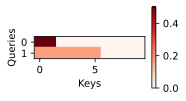

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 摘要

* 我们可以将注意力集中的输出计算为值的加权平均值，其中注意力评分功能的不同选择会导致不同的注意力集中行为。
* 当查询和密钥是不同长度的矢量时，我们可以使用加法注意力评分功能。当它们相同时，缩放的点-产品注意力评分功能在计算上更有效率。

## 练习

1. 修改玩具示例中的按键并可视化注意力重量。添加剂的注意力和缩放的点-产品的注意力是否仍然产生相同的注意力？为什么或为什么不？
1. 只使用矩阵乘法，您能否为具有不同矢量长度的查询和键设计新的评分函数？
1. 当查询和键具有相同的矢量长度时，矢量求和是否比计分函数的点积更好？为什么或为什么不？


[Discussions](https://discuss.d2l.ai/t/346)
